# Torchlight: A Network Trace Diffusion Cookbook
---

_a quick note of acknowledgement to Dr. Alefiya Hussain, who was invaluable throughout this course of exploration, providing guidance, encouragement, and insight all along the way._

There is, at current, a small crisis in the domain of network security. We live in a more online world than ever before, and yet, the exponential data oilstrikes that have happened across discplines that have powered forward into the age of deep learning and GenAI have yet to fruit for network security. The parallel development of stronger and stricter data privacy concerns and legal frameworks to protect them as well as the ever increasing resource demand it would take to match data labelling and processing efforts to the growth of the internet form a very strong bottleneck that new, innovative, and most importantly: representative datasets need to overcome.

A severe impairment of a field's availability of training data structurally impedes the development of machine learning and especially deep learning solutions in the space.


This contributes to a fervent interest in data _synthesis_ methods in the space. The most recent of which prior to the one in this post was a GAN-based method that produced a coarse-grained hauristic summary of a flow of packets. Because if you can't get it, maybe you can make it. The challenge here is preserving as much of the original traffic flow and information as possible. The representation is key.

Prior GAN based methodologies have been limited in their ability to generate raw, high-dimensional traces and often rely on aggregating flow characteristics, which results in data that lacks statistical fidelity to real data and performs much more poorly in machine learning tasks. The highly specific formatting of these types of condensed traces also renders them generally incompatible with traditional tools like Wireshark and tcpdump.

In recent years, the advent of diffusion models have solved many of the problems that plague older GAN frameworks, being able to capture much more complex patterns and relationships. They also usually offer much more stability in the training process, in which GANs are notably finnicky. Additionally, their now near- hegemony in the image generation space has enabled a wide base of development support in the diffusion community and has also made available many "plug and play" means of constraining generation to appropriate enough scopes for specific generation tasks like the one at hand.

This is one of those ideas that made no sense at all on first take. Using stable diffusion to generate __data__? And yet, when I read the paper by the UChicago lab that made it happen and went over the code, it was simply brilliant and brilliantly simple. The following is my process leveraging and refining their method, then applying it to a novel dataset with an intense statistical analyses of its capabilities. The results are there, and they _work_. And you can see it in the paper linked here. This writeup is about process.

I've divided this writeup into 3 main segments:
1. A succinct explanation of the networking ideas necessary for comprehension
2. The steps I took to generate the data
3. A comprehensive evaluation of the generated data

---
## the ideas & concept

The fundamental building block of all network traffic data is something called a `.pcap` file. It's the essentially universal data file imported and exported by all provisioners of network traffic monitoring, like Wireshark and tcpdump. Each piece of traffic encapsulated into a row - a single packet - encodes its headers (metadata about where it came & went from and how) and for most applications, the size of its payload. 

![what's inside](nbfigures/pcap_raw.png)

The field is often interested in the ballistics - where it came from, all the places it's bounced, and where it lands - of a packet. 

These kinds of movements patterns are often how security experts differentiate between normal traffic and traffic, for example, that may be being projected from a potential DDoS attack. 

The `nPrint` project created a more standard and more idiomatically usable file format for `pcap` files, a a consistent bit-mapped format, where the presence or absence of a bit in the packet header is denoted 1 or 0 respectively, and a missing header bit is represented as -1. Here's an example packet flow in the nPrint format:

![what's inside](nbfigures/plain_datafile.png)

The kicker is that instead of flattening this for input as we might do in that classic first case of MNIST, we take this much more as-is, in its 1088 x 1024 form. Local geography matters! And utilizing this 2D and much more spatially aware representation lends itself to seeing patterns like the grouping of TCP headers towards the end that stick out like a sore thumb here but wouldn't in a flattened manner. 

More importantly, since many of the driving modern advancement in computer vision hone in on this kind of spatiality - see CNNs & attention - there's actually no need to reinvent the wheel here. It's been done for us!

Using LoRA and constrained generation, which we will go into detail on in the following sections, we can leverage the already built-in and trained-in capabilities of modern large-scale diffusion models to generate these nPrint images as they are. We can use diffusion models to "manufacture" data.

### the dataset

The data used is the DARPA Searchlight dataset, which is a large collection of network traces from a variety of sources and applications. Searchlight was collected over a period of 6 months
and contains a wide variety of traffic types, including video streaming, web browsing, and file transfers all coordinated on a complex testbed that includes a variety of network devices and topologies, making it highly representative of real-world network traffic.

I decided to focus on video streaming using tiered topology traffic. All data is routed through a VPN, configured in either site- to-site (STS) or point-to-point (PTP) configuration, and a variety of video resolutions and streaming and transport protocols were used, all of which are shown in Table 1. In lieu of "micro-level" and "macro- level" service distinctions as made in the original NetDiffusion paper, we use these different labels to evaluate statistical differences and classification performance

There are 342 video experiments using tiered topology to record video traffic.

![what's inside](nbfigures/table1.png)

We focus on the four main categories: encryption, resolution, streaming protocol, and transport protoccol, to guide our statistical analysis and classification studies down the line.

---

## the blueprint for generation

Now that we have a collection of concepts we're cooking with, we're going to break down this process into a number of main moving parts:


1. Converting `pcap` files to images + color processing
2. LoRA fine-tuning a pretrained diffusion model using the images
3. Constrained generation using ControlNet
4. Heuristic + color post-processing

## 1. from data to image

### from pcap to nprint

Each `pcap` file is then downloaded from the Searchlight repository and converted into a 1024-truncated `nPrint` file. 

In [ ]:
def dataframe_to_png(df, output_file):
    width, height = df.shape[1], df.shape[0]
    padded_height = 1024
    print(output_file)
    # Convert DataFrame to numpy array and pad with blue pixels
    np_img = np.full((padded_height, width, 4), (0, 0, 255, 255), dtype=np.uint8)
    np_df = np.array(df.apply(lambda x: x.apply(np.array)).to_numpy().tolist())
    np_img[:height, :, :] = np_df

    # Create a new image with padded height filled with blue pixels
    img = Image.fromarray(np_img, 'RGBA')

    # Check if file exists and generate a new file name if necessary
    file_exists = True
    counter = 1
    file_path, file_extension = os.path.splitext(output_file)
    while file_exists:
        if os.path.isfile(output_file):
            output_file = f"{file_path}_{counter}{file_extension}"
            counter += 1
        else:
            file_exists = False

    img.save(output_file)

In [ ]:
for file in os.listdir(pcap_dir):
    print(file)
    filename = file.split('.pcap')[0]
    pcap_filename = f"{pcap_dir}/{file}"
    finetune_nprint_filename = f"{finetune_nprint_dir}/{filename}.nprint"
    print(f"creating nprint for {pcap_filename}")
    subprocess.Popen(f"nprint -F -1 -P {pcap_filename} -4 -i -6 -t -u -p 0 -c 1024 -W {finetune_nprint_filename}", shell=True).wait()
    print('done.')

    nprint_path = f"{finetune_nprint_dir}/{filename}.nprint"
    df = pd.read_csv(nprint_path)
    num_packet = df.shape[0]
    if num_packet != 0:
        try:
            substrings = ['ipv4_src', 'ipv4_dst', 'ipv6_src', 'ipv6_dst','src_ip']
            cols_to_drop = [col for col in df.columns if any(substring in col for substring in substrings)]
            df = df.drop(columns=cols_to_drop)
            cols = df.columns.tolist()
            for col in cols:
                # change bit values to rgba values
                df[col] = df[col].apply(int_to_rgba)

            output_file = f"{img_dir}/{filename}.png"
            # perform conversion
            dataframe_to_png(df, output_file)
        except Exception as e:
            print(e)
            continue

## 2. finetuning the base model

Diffusion models fundamentally operate on the principle of taking a randomly initialized amount of noise and iteratively refining it into an end-product image. This process is modeled by estimating the gradient of the log-likelihood of the data with respect to the noise vector, and then using this gradient to update the noise vector. Diffusion models typically operate in the context of "text-to-image" synthesis, where a text prompt guides the generation of an image by conditioning the noise vector on the text. This conditioning steers the data distribution from a general uniform prior distribution to a more specific one fitted to the text prompt.

![what's inside](nbfigures/ganvfig.png)

Diffusion models are adept at capturing highly complex and intricate relationships and thus generating high-resolution and high-fidelity images. The text conditioning also allows for a high degree of control over the generated images, as the text can be used to guide the generation process in a way that is not possible with other generative models. Lastly, diffusion models are highly stable and easy to train, as the adversarial training that GANs do is known to be highly prone to mode collapse. Their stable gradient dynamics and ability to be seeded in training ensures not just consistent but reproducible training results.


### captioning

Training a diffusion model from scratch is highly computationally intensive and expensive, considering that existing models are often trained on billions of images. Base models like Stable Diffusion are too broad for our purposes. While a text prompt like "pixelated network data: dash, 1080" is what we end up using in our end-stage model, the base model would produce something like a pixelated image of a dash, which is not useful for our purposes. Low-Rank Adaptation (LoRA) is a technique that allows us to fine- tune a pre-trained model on a smaller dataset. LoRA attaches a low-rank matrix to the model’s parameters and then trains just the low-rank matrix on a new dataset. This allows us to adapt the stylistic and color characteristics of the model to our specific dataset without having to retrain the entire model.

![what's inside](nbfigures/lorafig.png)

In the fine-tuning process, we attach to every image a caption that corresponds to the various characteristics of the image. For example, the image for a network flow using the Wireguard VPN streaming 1080p video using DASH over HTTP3 would be captioned "pixelated network data: wireguardptp, dash, 1080 hhtp3". Hundreds of such image-caption pairs are then used to fine-tune the model over the course of thousands of epochs to adapt the model to the specific color and stylistic characteristics of the images used to fine-tune it. The choice of caption is crucial and achieves two main objectives: it gives the model a specific vocabulary that reduces ambiguity and minimizes interference from the original word embeddings of the base model.

We build a caption for every image and put it into `metadata.jsonl` to be utilized during the fine-tuning process.

In [ ]:
print('making captions...')
captions = []
for file in os.listdir(img_dir):
	if '.png' in file:
		caption = f"pixelated network data: {file.split('-')[-3]}, {file.split('.')[-4]}, {file.split('.')[-3]} {file.split('.')[-2]}" 
		entry = {'file_name': file, 'text': caption}
		captions.append(entry)

with open(f"{img_dir}/metadata.jsonl", 'w') as f:
	for entry in captions:
		json.dump(entry, f)
		f.write('\n')

```
{"file_name": "1659056263-c1.wgsts.tiered.pharos-wireguardsts-a-video.1080.html5.http2.png", "text": "pixelated network data: wireguardsts, 1080, html5, http2"}
```

Where each entry looks something like that

![what's inside](nbfigures/meth2.png)

### fine-tuning

The fine-tuning process is actually quite straightforward, as long as you have the right hardware. I actually tried to do this a couple time on my M-series Mac, to very slow but eventual success. The final couple of runs were done on Lambda Labs cloud compute.

The script on its own looks like this:

In [ ]:
export MODEL_NAME='stabilityai/stable-diffusion-2'
export OUTPUT_DIR='model'
export DATASET_NAME='../../data/finetune_imgs'

accelerate launch train_text_to_image_lora.py \
	--pretrained_model_name_or_path=$MODEL_NAME \
	--train_data_dir=$DATASET_NAME \
	--dataloader_num_workers=0 \
	--resolution=512 --center_crop --random_flip \
	--train_batch_size=1 \
	--gradient_accumulation_steps=4 \
	--max_train_steps=12000 \
	--learning_rate=1e-04 \
	--max_grad_norm=1 \
	--lr_scheduler='cosine' --lr_warmup_steps=0 \
	--output_dir=${OUTPUT_DIR} \
	--checkpointing_steps=1500 \
	--seed=1337

where the `launch_train_text_to_image_lora.py` is a file you can find online. 

Run this for however many hours it needs to and it places the final Pytorch weights for the model in directory specified by `OUTPUT_DIR`. Easy peasy!

## 3. constrained generation

Even though fine-tuning can result in very high-quality output, it can be very abstract and deviate greatly from the stricter bounds of network traffic data. To constrain the output, we can employ a ControlNet, which is a separate neural network that sits atop the diffusion model and modifies the output to be rigidly within the bounds defined by the ControlNet. Generally, a ControlNet is trained on a specific type of spatial constraint, like poses, depth mapping, masks, or in our case, canny edge detection. 

![what's inside](nbfigures/cnet.png)

In the case of canny edge detection, the ControlNet takes as input a text prompt and the canny edges extracted from a sample image to use as "guardrails" to guide the diffusion model in generating the final image. ControlNet enables us to generate images that are not just high-quality, but also highly compliant with the structure of network traffic.

To start the process of generation, we load in the trained weights from our previous fine-tuning step.

In [ ]:
controlnet = ControlNetModel.from_pretrained('thibaud/controlnet-sd21-canny-diffusers', torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    'stabilityai/stable-diffusion-2', controlnet=controlnet, torch_dtype=torch.float16
).to('mps')
pipe.load_lora_weights('model/', weight_name='pytorch_lora_weights.safetensors')
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

This function `cannyize` extracts the canny edges from any given image

In [ ]:
def cannyize(image_path):
    img = Image.open(image_path)
    img = np.array(img)
    img = Canny(img, 100, 200)
    img = img[:, :, None]
    img = np.concatenate([img, img, img], axis=2)
    canny_img = Image.fromarray(img)
    return canny_img

In [ ]:
image_paths = (f"{img_dir}/{image}" for image in os.listdir(img_dir) if '.png' in image)
canny_images = ((cannyize(image_path), image_path.split('/')[-1]) for image_path in tqdm(image_paths))
image_labels = ((image_name, image, metadata[image_name]) for image, image_name in canny_images)

This is what's happening:

![what's inside](nbfigures/methiv.png)

In [ ]:
samples_per = 5
print('generating images...')
for image_name, canny_image, prompt in tqdm(image_labels):
    output = pipe(
        [prompt] * samples_per,
        canny_image,
        negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * samples_per,
        generator=[torch.Generator(device='mps').manual_seed(2) for _ in range(samples_per)],
        num_inference_steps=20,
    )
    for i, image in enumerate(output.images):
        image.save(f"../../data/synthesized_imgs/{image_name.split('.')[0]}_{i}.png")

The negative prompts here tell the model what kind of image not to produce, and we opt to generate 10 synthetic samples per image. That is to say, each of the 342 original samples will be a parent to 10 child images that are similar, but not identical. We're able to boostrap images, essentially.

## 4. post-processing

While the constrained diffusion model generates high-fidelity images that greatly resemble network traffic, we can see that there's still work to do. Here's a comparison:

![what's inside](nbfigures/methvi.png)

It actually matches up very closely with the original in terms of coloring and silhouette, but upon close inspection we can see how sloppy the generation is. Of course, this project was limited by my own resources. With more compute and traiing data, we can get this resolution up, but it'll inevitably always be a little bit low res in comparison to the original.

![what's inside](nbfigures/methvii.png)

Use outside of ML tasks require that the flows these images represent comply with network standards and the multitudes of inter and intra packet dependices that enable use in traditional networking applications. While ControlNet can do a lot to ensure resemblance, it cannot guarantee compliance. To this end, we must apply a series of post-processing steps to the generated images to ensure that they are compliant with network standards. Broadly, these rules can be put into two categories:

1. Inter-Packet: Rules that govern the sequencing between header fields between packets in a flow, like the SYN / SYN- ACK handshake that initiates a TCP connection, the incorrect alignment of which can cause the connection to fail.

2. Intra-Packet: Rules that organize the structure of individual packets, like the ordering of header fields within a packet and checksums that ensure the integrity of the packet.

![what's inside](nbfigures/dependencies.png)

The work of creating a systematic approach that comprehensively identifes and corrects these errors has been done by original NetDiffusion authors, and we have left their work in this area. The post-processing steps are fully automated and accomplished by traversing two intra-packet and inter-packet dependency trees built with domain knowledge. A notable challenge the authors faced was time-stamp assignment for packets, which was resolved by sampling original timestamps from real data to produce similar timestamp distributions in the synthetic data. This post-processing ensures that the generated traffic can be smoothly converted into raw network formats and utilized in non-ML contexts.

This code then performs color corrections to ensure the original bit-mappings then converts into `nPrint`.

In [ ]:
def png_to_dataframe(input_file):
    img = Image.open(input_file)
    width, height = img.size
    print(width)
    print(height)
    data = []

    for y in range(height):
        row = []
        for x in range(width):
            rgba = img.getpixel((x, y))
            #print(rgba)
            row.append(rgba_to_int(rgba))
        data.append(row)

    return pd.DataFrame(data, columns=cols)

---

## the evaluation

So we cooked up 3420 synthesized data samples. How do we know if it's good or not? We use two methods:
1. Using Jensen-Shannon distance to compare parent and child images
2. Comparing classification performance

We see how and how much the synthesized data diverges from the original data and how classification performs in various scenarios.

In [ ]:
realdata, realkeys = get_datafiles(real_nprints_dir, return_keys=True)
synthdata, synthkeys = get_datafiles(synth_nprints_dir, return_keys=True)

reading nprints from ../../data/finetune_nprints...


  0%|          | 0/432 [00:00<?, ?it/s]

100%|██████████| 432/432 [01:49<00:00,  3.95it/s]


reading nprints from ../../data/generated_nprint...


100%|██████████| 3240/3240 [17:10<00:00,  3.14it/s]


### statistical comparison

The core premise of generating synthetic data is to try to achieve a robust statistical resemblance to the original data. The statistical measure we opt for is Jensen-Shannon distance (JSD), which is a symmetric and finite measure of the similarity between two probability distributions. The JSD between two distributions is calculated by first computing the KL divergence between the two distributions and taking the average. The JSD is bounded between 0 and 1, with 0 indicating that the two distributions are identical and 1 indicating that the two distributions are completely different. In our case, we take the JSD between each synthetic example and its "parent" image that provided edges to the ControlNet.

In [ ]:
real_labels = [get_label(key) for key in realkeys]
unencoded_labels = {key: [] for key in realdata['labels']}
for item in real_labels:
	for key in unencoded_labels:
		unencoded_labels[key].append(item[key])

In [ ]:
distances = {}
for label in unencoded_labels:
	encoded_pairs = [[(label, dist) for dist in dists] for label, dists in zip(unencoded_labels[label], jsd_list)]
	label_pairs = ([item for sublist in encoded_pairs for item in sublist])
	distances[label] = label_pairs

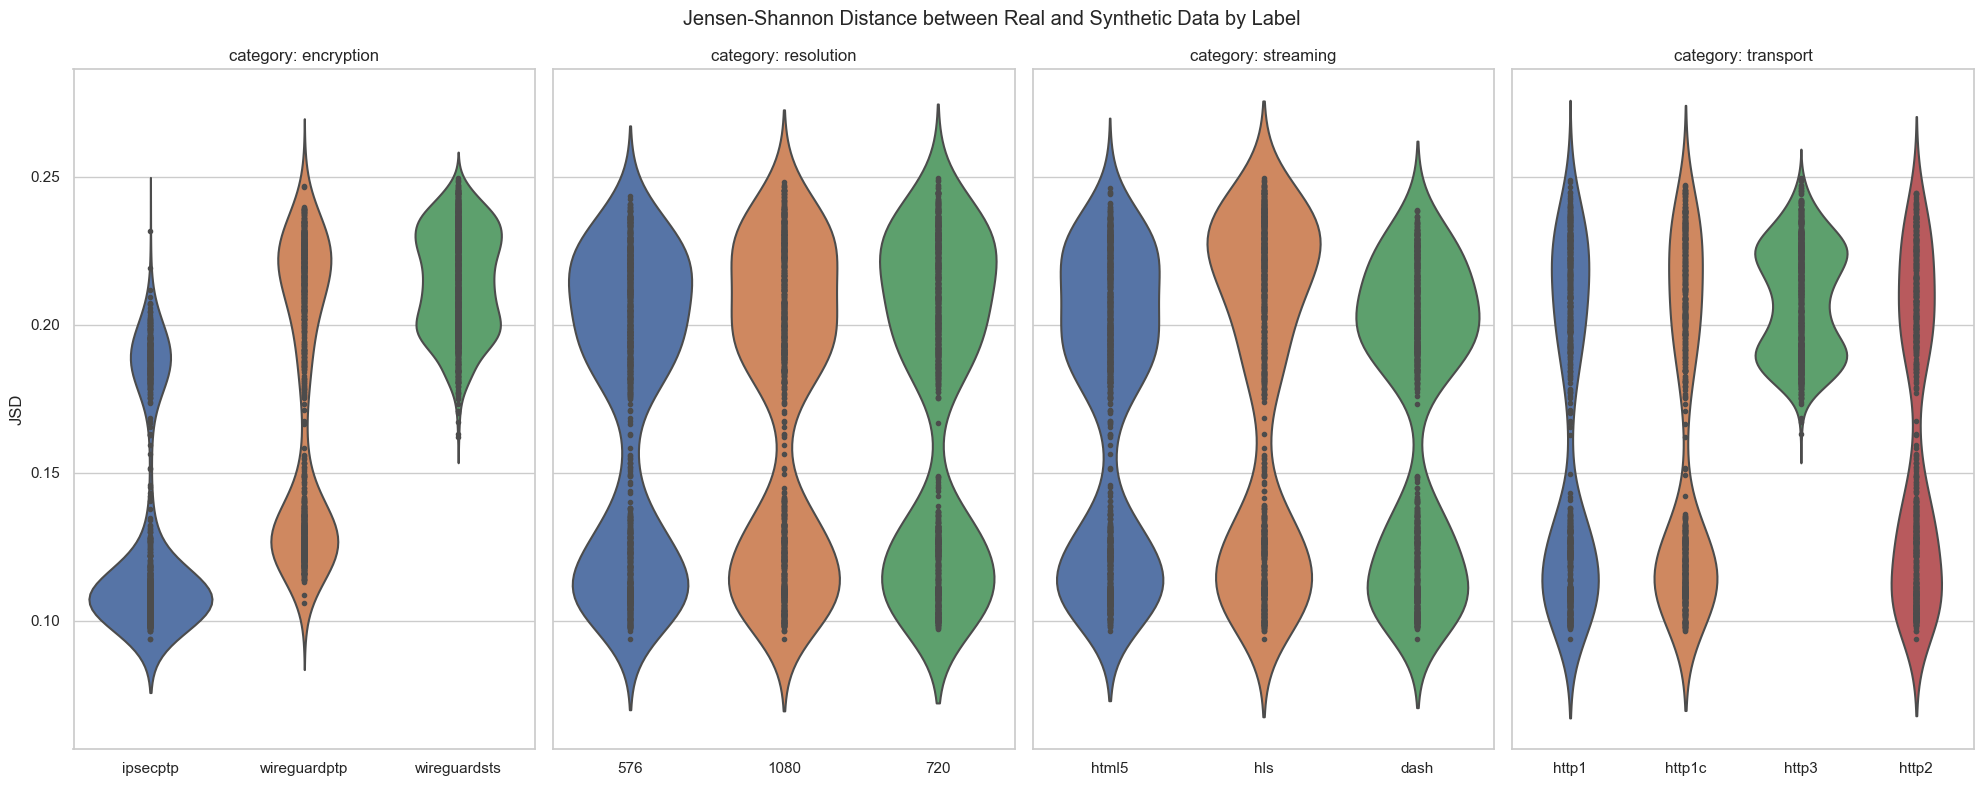

In [ ]:
fig, axes = plt.subplots(1, len(distances), figsize=(20, 8), sharey=True)
for label, ax in zip(distances, axes):
	x, y = list(zip(*distances[label]))
	_ = sns.violinplot(
			x=np.array(x), y=np.array(y), ax=ax,
			saturation=0.8, inner='point'
		)
	_ = ax.set_title(f"category: {label}")

_ = axes[0].set_ylabel('JSD')
_ = fig.suptitle('Jensen-Shannon Distance between Real and Synthetic Data by Label')
_ = fig.set_tight_layout(True)
fig.savefig('figures/jsd_violin.png', bbox_inches='tight', dpi=300)

The deviations tend to be bimodal, with large amounts centered around 0.10 or around 0.20. The syntheitc data seems to generally capture resolution and streaming information relatively uniformly while for encryption and transport it seems to perform markedly better on some classes and worse on others.

### classification results

For classification tasks, we use three main models: decision trees, random forests, support vector machines. Accuracy is the metric used, as classes are exactly balanced and accuracy is a good mea- sure of overall performance. A model is trained for every category, performing multi-class classification at each instance. We tested performance in four distinct scenarios:

1. Train on real data, test on real data: Using 5-fold cross validation done over 10 runs, evaluate multi-class performance on all three models on every category, giving a clear baseline as to how well the models can perform on the original data.
2. Train on synthetic data, test on real data: Using traditional train-test splitting at a 4:1 ratio, done over 100 runs, we train each model using only synthetic data and test on real data, maintaining the size (342) to ensure a fair comparison
3. Train on real data, test on synthetic data: Using traditional train-test splitting at a 4:1 ratio, done over 100 runs, we train each model using real data and test on synthetic data, maintaining the size (342) to ensure a fair comparison.
4. Mixed data proporrtions: Using traditional train-test splitting at a 4:1 ratio done over 100 runs, after splitting, we replace some proportion 𝑝 of the training data with synthetic data, where 𝑝 ∈ {0.1, . . . , 0.9} and test on all real data with random forests to evaluate performance in a data augmentation scenario.

### _results on no & complete synthetic data usage_

In [ ]:
def mix_data(realdata, synthdata, realkeys, synthkeys, n=32):
	n = int(n * realdata['data'].shape[0])
	synarr = np.array([f"{item.split('_')[0]}.nprint" for item in synthkeys])
	to_replace = np.random.choice(len(realkeys), n, replace=False)
	available_indices = [(synarr == realkeys[idx]).nonzero()[0] for idx in to_replace]
	replacing_indices = [np.random.choice(indices, 1)[0] for indices in available_indices]

	copydata = realdata['data'].copy()
	copydata[to_replace] = synthdata['data'][replacing_indices]
	return copydata

def subsample(synthdata, synthkeys, realkeys, n=1):
	synarr = np.array([f"{item.split('_')[0]}.nprint" for item in synthkeys])
	buckets = [(synarr == key).nonzero()[0] for key in realkeys]
	sampled_indices = (np.hstack([np.random.choice(bucket, n) for bucket in buckets]))
	data = synthdata['data'][sampled_indices]
	labels = {key: value[sampled_indices] for key, value in synthdata['labels'].items()}
	return {'data': data, 'labels': labels}

In [ ]:
# train on real, test on real
nresults = []
for i in tqdm(range(10)):
    results = defaultdict(dict)
    for label, Y in realdata['labels'].items():
        models = {
            'dt': DecisionTreeClassifier(random_state=42),
            'rf': RandomForestClassifier(n_estimators=100, random_state=42),
            'svc': SVC(kernel='linear', C=1.0, random_state=42),
        }
        for name, model in models.items():
            cv_scores = cross_val_score(model, realdata['data'], Y, cv=5)
            mean_acc = cv_scores.mean()
            results[label][name] = mean_acc
    nresults.append(results)

100%|██████████| 10/10 [2:57:45<00:00, 1066.55s/it] 


In [ ]:
# training on synthetic, testing on real
nresults = []
for i in tqdm(range(1, 101), leave=False):
	results = defaultdict(dict)
	for label, Y in realdata['labels'].items():
		indices = np.arange(realdata['data'].shape[0])
		X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(realdata['data'], Y, indices, test_size=0.2, random_state=42)
		X_train = mix_data({'data': X_train}, synthdata, np.array(realkeys)[idx_train], synthkeys, n=1)
		models = {
			'dt': DecisionTreeClassifier(random_state=42),
			'rf': RandomForestClassifier(n_estimators=100, random_state=42),
			'svc': SVC(kernel='linear', C=1.0, random_state=42)
		}
		for name, model in models.items():
			_ = model.fit(X_train, y_train)
			y_pred = model.predict(X_test)
			acc = accuracy_score(y_test, y_pred)
			results[label][name] = acc
	nresults.append(results)

In [ ]:
# training on synthetic, testing on real
nresults = []
for i in tqdm(range(1, 101), leave=False):
	results = defaultdict(dict)
	for label, Y in realdata['labels'].items():
		indices = np.arange(realdata['data'].shape[0])
		X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(realdata['data'], Y, indices, test_size=0.2, random_state=42)
		X_test = mix_data({'data': X_test}, synthdata, np.array(realkeys)[idx_test], synthkeys, n=1)
		models = {
			'dt': DecisionTreeClassifier(random_state=42),
			'rf': RandomForestClassifier(n_estimators=100, random_state=42),
			'svc': SVC(kernel='linear', C=1.0, random_state=42),
		}
		for name, model in models.items():
			_ = model.fit(X_train, y_train)
			y_pred = model.predict(X_test)
			acc = accuracy_score(y_test, y_pred)
			results[label][name] = acc
	nresults.append(results)

![what's inside](nbfigures/perf.png)

The results presented in Table 2 illustrate that the data performs reasonably well in classification tasks. The drop in performance when using synthetic data is expected, as the synthetic data is not perfect and will not capture all the intricacies of the real data. The drop in performance is most pronounced in the encryption and transport categories, which is likely due to the complexity of these categories and the difficulty in capturing the nuances of these categories in the synthetic data. The performance of the models doesn’t deviate as much for resolution and streaming, which the real/real models don’t perform as well on in their own right. Lastly an interesting comparison is the performance of the models trained on real data and tested on synthetic data, which actually relatively closely to the performance of the models trained on synthetic data, which shows that the synthetic data is still able to capture a robust amount of the patterns inherent in the real data.

### _results on mixed data_

In [ ]:
mixing_rates = [round(rate, 1) for rate in np.arange(0, 1.1, 0.1)]

nresults = []
for i in range(1, 101):
	results = defaultdict(list)
	for j, (label, Y) in enumerate(realdata['labels'].items(), 1):
		for rate in tqdm(mixing_rates, leave=False, desc=f"run {i} - evaluating {label} ({j}/{len(realdata['labels'])})"):
			indices = np.arange(realdata['data'].shape[0])
			X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(realdata['data'], Y, indices, test_size=0.2, random_state=42)
			X_train = mix_data({'data': X_train}, synthdata, np.array(realkeys)[idx_train], synthkeys, n=rate)
			model = RandomForestClassifier(n_estimators=100, random_state=42)
			_ = model.fit(X_train, y_train)
			y_pred = model.predict(X_test)
			acc = accuracy_score(y_test, y_pred)
			results[label].append((rate, acc))
	nresults.append(results)

results = defaultdict(list)
num_entries = len(nresults)

for i, rate in enumerate(mixing_rates):
    for key in nresults[0].keys():
        average = sum(entry[key][i][1] for entry in nresults) / num_entries
        results[key].append((round(rate, 1), average))

results = dict(results)

with open('results/mix_results.json', 'w') as f:
	json.dump(results, f, indent=4)

In [ ]:
results = defaultdict(list)
num_entries = len(nresults)

for i, rate in enumerate(mixing_rates):
    for key in nresults[0].keys():
        average = sum(entry[key][i][1] for entry in nresults) / num_entries
        results[key].append((round(rate, 1), average))

results = dict(results)

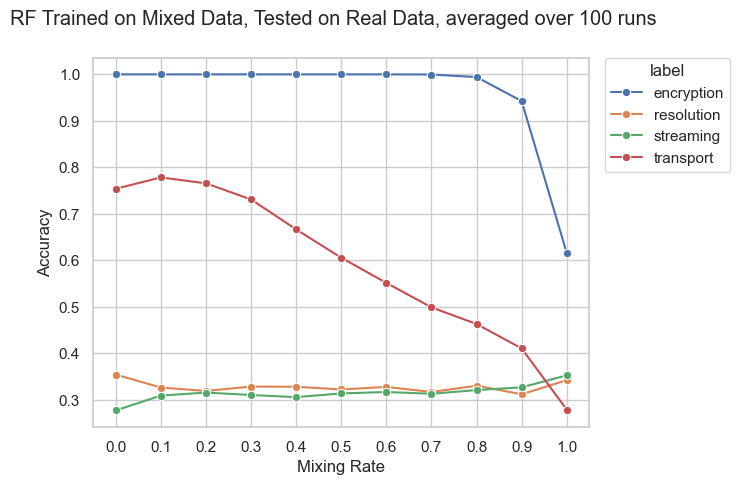

In [ ]:
fig, ax = plt.subplots()
for key, entry in results.items():
	_ = sns.lineplot(x=[item[0] for item in entry], y=[item[1] for item in entry], label=key, ax=ax, marker='o')

_ = ax.legend(title='label', loc='upper right', bbox_to_anchor=(1.3, 1.02))
_ = fig.suptitle("RF Trained on Mixed Data, Tested on Real Data, averaged over 100 runs")
_ = plt.xlabel('Mixing Rate')
_ = plt.xticks(np.arange(0, 1.1, 0.1))
_ = plt.ylabel('Accuracy')
plt.show()

Presented in the figure is the performance of the random forest model as the mixing rate goes from 0 to 1, and observable is the progression of performance. Notably encryption stays relatively stable until all of the data is replaced and streaming protocol actually improves with a small amount of synthetic data and then falls off quickly as more real data is replaced. Resolution reamins relatively stable all throughout and streaming actually improves near monotonically with the addition of synthetic data. This also provides an extension to the performance comparisons in Table 2, showing that the synthetic data can be used effectively as an augmentation tool. 

And that's a super important takeway from this project. Generative techniques as they exist currently aren't sought after to replace traditional datasets wholsale. Rather, they give us tools to _augment_ these datasets and provide generalization and class imbalance nullfication capabilites the original datasets might not be able to work with.

### feature importances

Another essential way to observe the fidelity of the synthetic data is to compare the feature importance of the models trained on real and synthetic data. Using random forests and training over 100 runs, we take the 10 most important features of each run and collect the 10 most commonly occuring features. We see that there’s at least some overlap in the features that are most important to the models, which is a good sign that the synthetic data is capturing important patterns in the real data.

In [ ]:
df = pd.read_csv('../../data/finetune_nprints/1659049691-c1.ipsecsts.tiered.pharos-ipsecsts-a-video.576.html5.http1.nprint')
substrings = ['ipv4_src', 'ipv4_dst', 'ipv6_src', 'ipv6_dst','src_ip', 'Unnamed: 0']
cols_to_drop = [col for col in df.columns if any(substring in col for substring in substrings)]
df = df.drop(columns=cols_to_drop)
column_names = df.columns
flattened_cnames = [[f"{name}_{i}" for name in column_names] for i in range(1024)]
flattened_cnames = np.array([item for sublist in flattened_cnames for item in sublist])

In [ ]:
nresults = []
for i in tqdm(range(1, 101), leave=False):
	results = defaultdict(dict)
	for label, Y in realdata['labels'].items():
		indices = np.arange(realdata['data'].shape[0])
		X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(realdata['data'], Y, indices, test_size=0.2, random_state=42)
		X_train = mix_data({'data': X_train}, synthdata, np.array(realkeys)[idx_train], synthkeys, n=1)
		model = RandomForestClassifier(n_estimators=100, random_state=42)
		_ = model.fit(X_train, y_train)
		importances = model.feature_importances_
		indices = np.argsort(importances)[::-1][:10]
		results[label] = flattened_cnames[indices]
	nresults.append(results)

results = {key: [] for key in nresults[0].keys()}
for entry in nresults:
	for key, value in entry.items():
		results[key].append(value)

results = {key: np.hstack(value) for key, value in results.items()}
top_synth_features = {key: [ent for ent, _ in Counter(['_'.join(item.split('_')[:-1]) for item in value]).most_common(10)] for key, value in results.items()}

with open('results/important_synth_features.json') as file:
	json.dump(top_synth_features, file, indent=4)

In [ ]:
nresults = []
for _ in tqdm(range(100)):
	results = defaultdict(dict)
	for label, Y in realdata['labels'].items():
		model = RandomForestClassifier(n_estimators=100, random_state=42)
		cv_results = cross_validate(model, realdata['data'], Y, cv=2, return_estimator=True)
		nfeatures = []
		for estimator in cv_results['estimator']:
			importances = estimator.feature_importances_
			indices = np.argsort(importances)[::-1][:10]
			nfeatures.append(flattened_cnames[indices])
		nfeatures = np.hstack(nfeatures)
		top_features = [ent for ent, _ in Counter(['_'.join(item.split('_')[:-1]) for item in nfeatures]).most_common(10)]
		results[label] = top_features
	nresults.append(results)

100%|██████████| 100/100 [20:43<00:00, 12.43s/it]


In [ ]:
sumresults = {key: [] for key in nresults[0].keys()}
for entry in nresults:
	for key, value in entry.items():
		sumresults[key].extend(value)

top_real_features = {key: [ent for ent, _ in Counter(value).most_common(10)] for key, value in sumresults.items()}
top_real_features

{'encryption': ['udp_sport_4',
  'udp_dport_1',
  'ipv4_hl_3',
  'ipv4_foff_12',
  'ipv4_tl_5',
  'udp_dport_4',
  'ipv4_tos_6',
  'ipv4_tl_13',
  'ipv4_proto_5',
  'ipv4_tl_10'],
 'resolution': ['ipv4_ttl_3',
  'ipv4_tl_11',
  'udp_len_13',
  'udp_cksum_14',
  'ipv4_cksum_15',
  'ipv4_id_7',
  'tcp_seq_10',
  'ipv4_cksum_10',
  'tcp_wsize_12',
  'ipv4_tl_5'],
 'streaming': ['udp_len_5',
  'ipv4_tl_13',
  'ipv4_id_13',
  'udp_cksum_0',
  'ipv4_id_14',
  'ipv4_tl_11',
  'udp_cksum_2',
  'tcp_seq_15',
  'ipv4_cksum_4',
  'udp_cksum_13'],
 'transport': ['udp_len_12',
  'ipv4_tl_9',
  'tcp_sprt_15',
  'udp_sport_3',
  'udp_sport_15',
  'udp_dport_15',
  'udp_sport_14']}

![what's inside](nbfigures/feats.png)

This table shows the 10 most important RF features for real/real and synthetic/real classification, with shared header fields highlighted in green

The results here definitely track with the results we see in both completely partitioned performance as well as the data mixing performance, indicating that the generated data is similar enough, especially for Encryption, for the models to focus on similar features.

---
# epilogue

I do want to acknowledge the limitations here. The diffusion process is expensive still, and 1024 is still a relatively limited frame to work with. I've played with the ideas of using a averaged sliding window or LSTMs for classification, nothing too tangible has come out of it yet. I think the real game changer here is the robustness of augmentation. We don't necessarily need to create entire datasets whole cloth. More often than not, when we have some data in place, it makes a lot more sense to bootstrap, and in this case, to generate some data to round out class imbalances and create a more representative training sample.

Having been initially exposed to diffusion a sort of image-making fun box, fine-tuning and guiding a diffusion model to accomplishing a narrowly defined and almost surgical task was an amazing first-hand learning experience. I think this really exemplifies how we are in a new age for generative techniques, and I hope ideas and techniques like NetDiffusion help us solve analogous problems in other fields. 